In [1]:
import numpy as np
import pandas as pd

from neurodsp.filt import filter_signal
from bycycle.features import compute_features
from bycycle.burst import plot_burst_detect_params
from scipy import stats
from scipy.io import loadmat
from collections import defaultdict

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
plt.style.use('Cole_2018.mplstyle')

from config import config_sim

# A-B. Example raw traces

In [2]:
# Load data
idx = 0
data = loadmat('data/PDdata.mat', struct_as_record=False, squeeze_me=True)
Fs = 1000
f_range = (13,30)
osc_detect_kwargs = {'amplitude_fraction_threshold':.2,
                     'amplitude_consistency_threshold':.3,
                     'period_consistency_threshold':.5,
                     'monotonicity_threshold':.6,
                     'N_cycles_min':3}

In [3]:
data_filt = defaultdict(list)
f_lowpass = 80
filter_seconds = .3
for k in ['B', 'D']:
    for s in range(len(data[k])):
        x_temp = filter_signal(data[k][s], Fs, 'lowpass', f_lowpass,
                                 n_seconds=filter_seconds,
                                 compute_transition_band=False,
                                 remove_edge_artifacts=False)
        data_filt[k].append(x_temp)

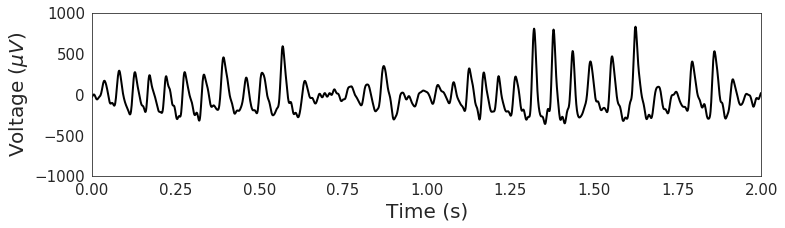

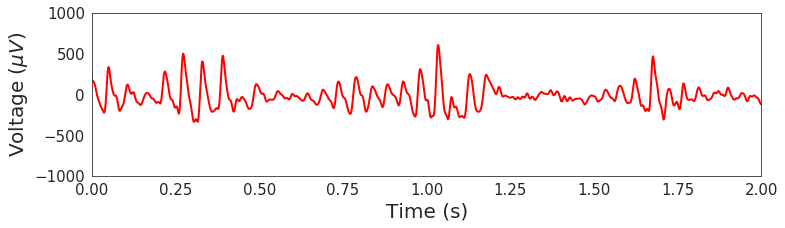

In [4]:
xB = data_filt['B'][idx]
xD = data_filt['D'][idx]
tB = np.arange(0, len(xB)/Fs, 1/Fs)
tD = np.arange(0, len(xB)/Fs, 1/Fs)
ymax = 1000

tlimB = np.array([3,5])
tidxB = np.logical_and(tB >= tlimB[0], tB < tlimB[1])
plt.figure(figsize=(12,3))
plt.plot(tB[tidxB]-tlimB[0], xB[tidxB], 'k', linewidth=2)
plt.xlim(tlimB-tlimB[0])
plt.ylim((-ymax, ymax))
plt.ylabel('Voltage ($\mu V$)')
plt.xlabel('Time (s)')
plt.savefig('figs/6A_preDBS_time_series.png', bbox_inches='tight')

tlimD = np.array([14,16])
tidxD = np.logical_and(tD >= tlimD[0], tD < tlimD[1])
plt.figure(figsize=(12,3))
plt.plot(tD[tidxD]-tlimD[0], xD[tidxD], 'r', linewidth=2)
plt.xlim(tlimD-tlimD[0])
plt.ylim((-ymax, ymax))
plt.ylabel('Voltage ($\mu V$)')
plt.xlabel('Time (s)')
plt.savefig('figs/6B_onDBS_time_series.png', bbox_inches='tight')

# C-F. Distributions of cycle features for DBS on and off

In [5]:
# Compute shape features and detect oscillating cycles
dfB = compute_features(xB, Fs, f_range, center_extrema='P',
                       burst_detection_kwargs=osc_detect_kwargs)
dfD = compute_features(xD, Fs, f_range, center_extrema='P',
                       burst_detection_kwargs=osc_detect_kwargs)

/Users/scott/anaconda/envs/shapyspiky/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/scott/anaconda/envs/shapyspiky/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


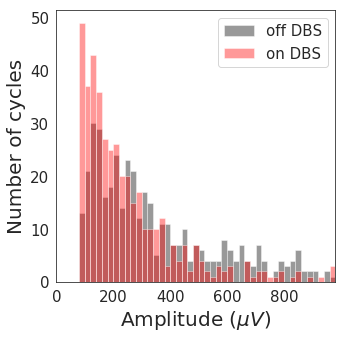

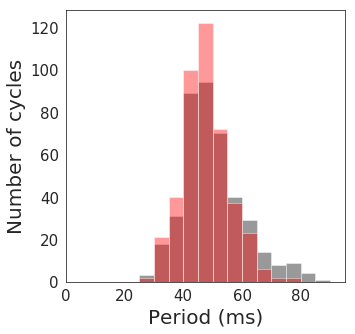

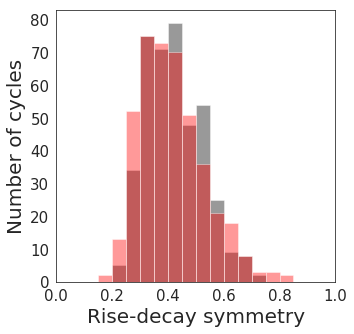

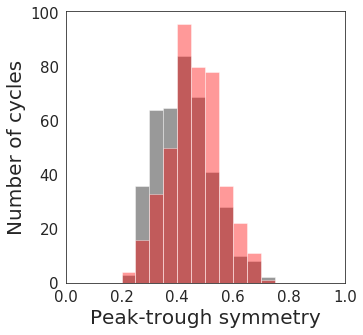

In [6]:
# Make distributions of features, comparing DBS condition
feat_names = {'volt_amp': 'Amplitude ($\mu V$)',
              'period': 'Period (ms)',
              'time_rdsym': 'Rise-decay symmetry',
              'time_ptsym': 'Peak-trough symmetry'}
feat_figletter = {'volt_amp': 'C', 'period': 'D',
                  'time_rdsym': 'E', 'time_ptsym': 'F'}
feat_bins = {'volt_amp': np.arange(0, 1000, 20),
             'period': np.arange(0, 100, 5),
             'time_rdsym': np.arange(0, 1.05, .05),
             'time_ptsym': np.arange(0, 1.05, .05)}

for feat, name in feat_names.items():
    plt.figure(figsize=(5,5))
    sns.distplot(dfB[dfB['is_burst']][feat], bins=feat_bins[feat], 
                 color='k', kde=False, label='off DBS')
    sns.distplot(dfD[dfD['is_burst']][feat], bins=feat_bins[feat], 
                 color='r', kde=False, label='on DBS')
    if feat == 'volt_amp':
        plt.legend(fontsize=15)
    plt.ylabel('Number of cycles')
    plt.xlabel(name)
    plt.xlim((feat_bins[feat][0], feat_bins[feat][-1]))
    plt.savefig('figs/6{:s}_{:s}_dist_onoffDBS.png'.format(feat_figletter[feat], feat), bbox_inches='tight')

# Compute asymmetry of cycles
Absolute difference between ptsym (or rdsym) and 0.5

In [7]:
dict_pd = defaultdict(list)
feats = ['volt_amp', 'period', 'time_rdsym2', 'time_ptsym2']
dfsB = []
dfsD = []
for s in range(len(data_filt['B'])):
    # Get time series for this subject
    xB = data_filt['B'][s]
    xD = data_filt['D'][s]

    # Compute shape features and detect oscillating cycles
    dfB = compute_features(xB, Fs, f_range, center_extrema='P', burst_detection_kwargs=osc_detect_kwargs)

    dfD = compute_features(xD, Fs, f_range, center_extrema='P', burst_detection_kwargs=osc_detect_kwargs)
    
    # Compute new ptsym and rdsym
    for feat in ['time_rdsym', 'time_ptsym']:
        dfB[feat+'2'] = np.abs(dfB[feat] - .5)
        dfD[feat+'2'] = np.abs(dfD[feat] - .5)

    # Save mean and median of each feature for each recording
    dict_pd['subject'].append(s)
    for feat in feats:
        dict_pd[feat+'_dbsoff_mean'].append(dfB[dfB['is_burst']][feat].mean())
        dict_pd[feat+'_dbson_mean'].append(dfD[dfD['is_burst']][feat].mean())
        
    # Compute the feature differences for amp and period
    for feat in feats:
        dict_pd[feat+'_diff_mean'].append(dfD[dfD['is_burst']][feat].mean() - dfB[dfB['is_burst']][feat].mean())
    dfsB.append(dfB)
    dfsD.append(dfD)
        
df_pd = pd.DataFrame(dict_pd)

# G. Peak-trough asymmetry DBS effect for all subjects

DBS on vs. DBS off, volt_amp_diff_mean WilcoxonResult(statistic=84.0, pvalue=0.10050558691972779)
DBS on vs. DBS off, period_diff_mean WilcoxonResult(statistic=90.0, pvalue=0.14431267887665597)
DBS on vs. DBS off, time_rdsym2_diff_mean WilcoxonResult(statistic=102.0, pvalue=0.2735436610893661)
DBS on vs. DBS off, time_ptsym2_diff_mean WilcoxonResult(statistic=61.0, pvalue=0.019183212767887602)


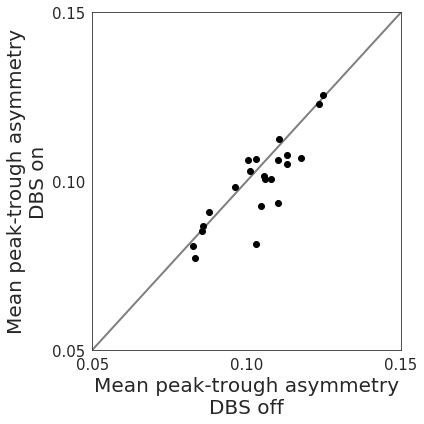

In [8]:
for col in df_pd.filter(like='diff').columns:
    print('DBS on vs. DBS off,', col, stats.wilcoxon(df_pd[col]))
    
plt.figure(figsize=(6,6))
lims = (.05, .15)
plt.plot(df_pd['time_ptsym2_dbsoff_mean'], df_pd['time_ptsym2_dbson_mean'], 'k.', ms=12)
plt.plot(lims, lims, 'k', alpha=.5)
plt.xlabel('Mean peak-trough asymmetry\nDBS off')
plt.ylabel('Mean peak-trough asymmetry\nDBS on')
plt.xlim(lims)
plt.ylim(lims)
plt.xticks([.05, .1, .15])
plt.yticks([.05, .1, .15])
plt.tight_layout()
plt.savefig('figs/6G_ptsym_DBS_effect.png', bbox_inches='tight')

# Assure burst detection looks good

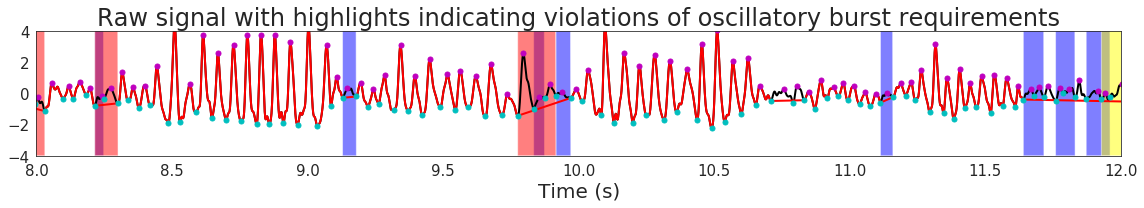

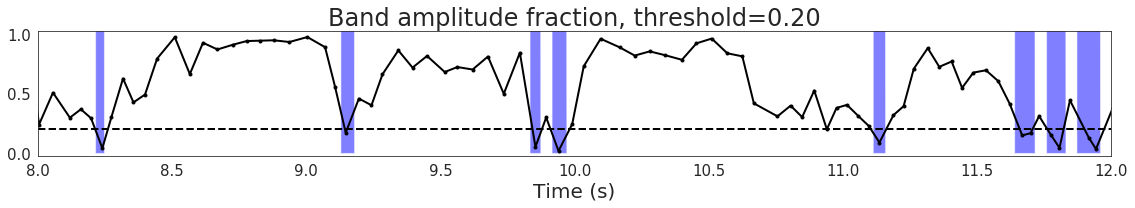

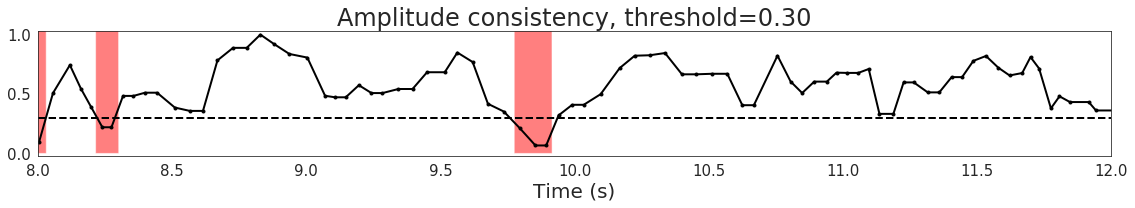

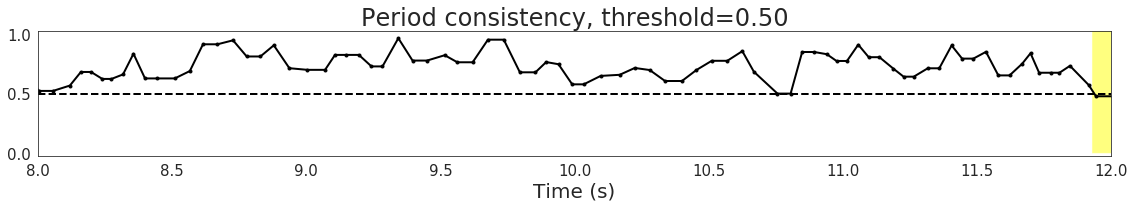

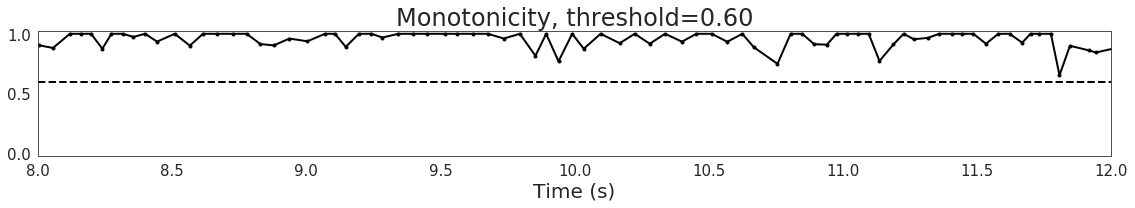

In [9]:
# Define signal of interest
s = 0
tlims = (8, 12)

x = data_filt['B'][s]
df_plt = dfsB[s]
t = np.arange(0, len(x)/Fs, 1/Fs)
plot_burst_detect_params(x, Fs, df_plt, osc_detect_kwargs, tlims=tlims)

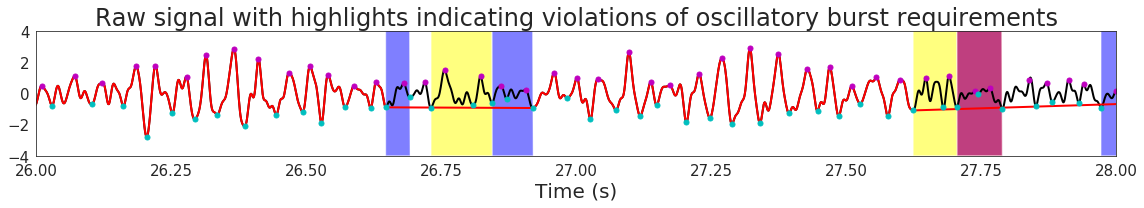

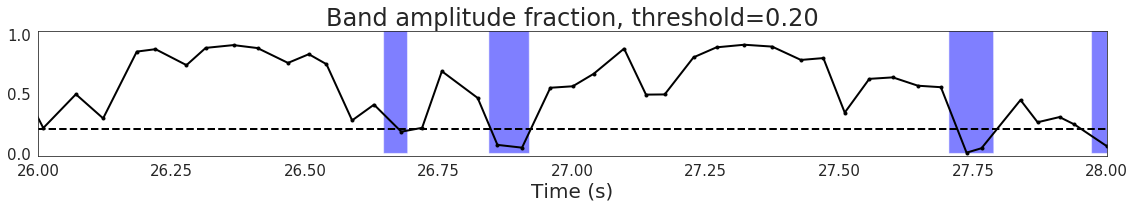

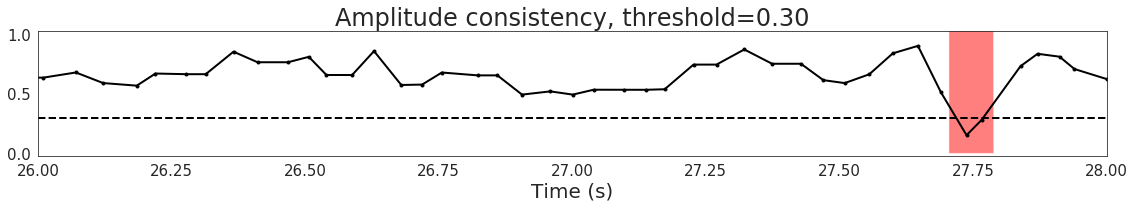

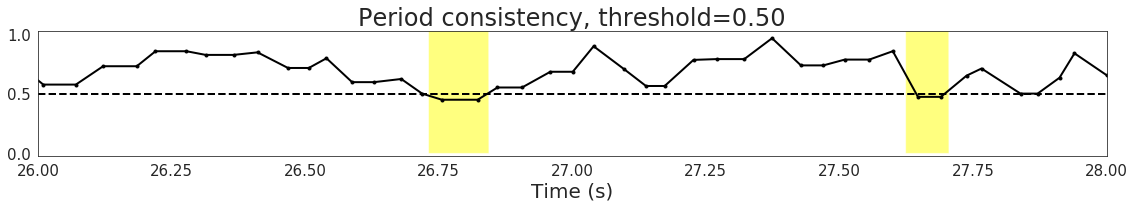

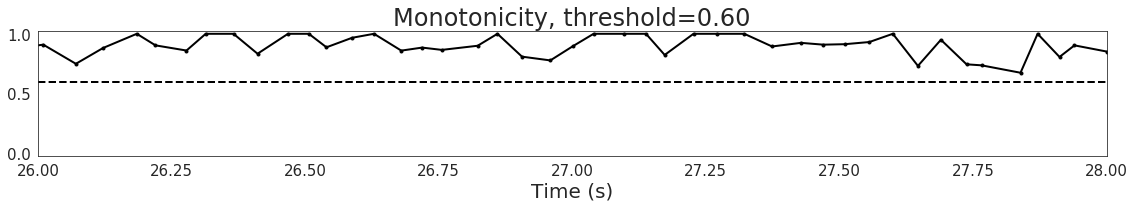

In [10]:
# Define signal of interest
s = 2
tlims = (26, 28)

x = data_filt['B'][s]
df_plt = dfsB[s]
t = np.arange(0, len(x)/Fs, 1/Fs)
plot_burst_detect_params(x, Fs, df_plt, osc_detect_kwargs, tlims=tlims)